# Data Preprocessing: Asset Class Returns

An asset class is a grouping of investments that exhibit similar characteristics and are subject to the same laws and regulations. Asset classes are thus made up of instruments that often behave similarly to one another in the marketplace [[Akhilesh Ganti, Investopedia]](https://www.investopedia.com/terms/a/assetclasses.asp).

In this notebook, we will download data for 8 broad asset classes. For each asset class, we identify some security that represents the general market for that asset class. This could be an index fund, an ETF, or a prominent asset.
1. Large Cap Equities: `VOO`
2. Small Cap Equities: `VBR`
3. Fixed Income (Bonds): `VBTLX`
4. Cash Equivalent: `GSY`
5. Real Estate: `VNQ`
6. Commodities: `BCD`
7. Cryptocurrencies: `BTC`
8. Gold: `GLD`

## Setup

In [1]:
# This notebook runs from the projects root directory.
import os
PROJECT_ROOT_DIRECTORY = 'senior_project'
while os.path.basename(os.getcwd()) != PROJECT_ROOT_DIRECTORY:
    os.chdir(os.pardir)
print('Current working directory:', os.getcwd())

Current working directory: c:\Users\pavan\Desktop\senior_project


In [2]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import talib as ta

## Download Data

In [3]:
TICKERS = {
    'LARGE_CAP' : 'VOO',
    'SMALL_CAP' : 'VBR',
    'BONDS' : 'VBTLX',
    'CASH' : 'GSY',
    'REAL_ESTATE' : 'VNQ',
    'COMMODITIES' : 'USCI',
    # 'CRYPTO' : 'BTC-USD',
    'GOLD' : 'GLD'
}

# 10 years of data (going through COVID-19)
TRAIN_START = '2011-01-01'
TRAIN_END = '2021-12-31'

# 1 year recession period
VAL_START = '2022-01-01'
VAL_END = '2022-12-31'

# 3 months after
TEST_START = '2023-01-01'
TEST_END = '2023-03-01'

In [4]:
data = {}
for ticker in tqdm(TICKERS.values()):
    data[ticker] = yf.download(
        ticker,
        start = TRAIN_START,
        end = TEST_END,
        interval = '1d',
        progress = False
    )

  0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
df = pd.DataFrame(index=pd.date_range(start=TRAIN_START, end=TEST_END, freq='d')) # create a dataframe with a full index

for ticker in TICKERS.values():
    df[ticker] = data[ticker]['Adj Close'].pct_change(1) # fill in each return column
    df[f'{ticker}_VOLUME'] = data[ticker]['Volume'].pct_change(1)
print(f'Number of all NaN rows dropped: {df.isna().all(axis=1).sum()}')
df.dropna(axis=0, how='all', inplace=True) # drop rows with all NaN e.g first row, weekends, public holidays

Number of all NaN rows dropped: 1385


In [6]:
df = pd.DataFrame(index=pd.date_range(start=TRAIN_START, end=TEST_END, freq='d')) # create dataframe with a full index

for asset_class, ticker in TICKERS.items():
    df[asset_class] = data[ticker]['Adj Close'].pct_change(1)
    # volume = data[ticker]['Volume']
    # df[f'{asset_class}_VOLUME'] = (volume - volume.mean()) / volume.std()

df.dropna(axis=0, how='all', inplace=True) # drop rows with all NaN e.g first row, weekends, public holidays
df.fillna(value=0, inplace=True) # fill any remaining missing values with 0

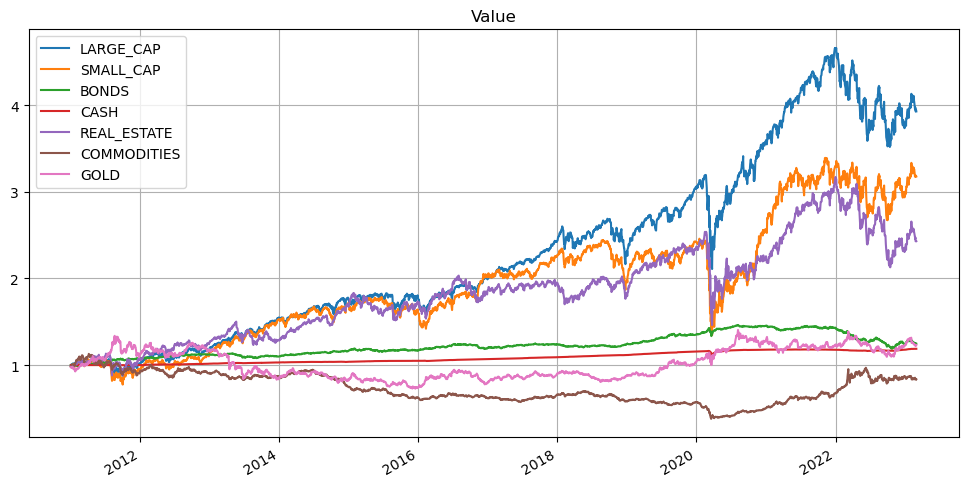

In [7]:
(1+df[TICKERS.keys()]).cumprod().plot(title='Value', figsize=(12, 6), grid=True);

## Generate Stationary Features

In [8]:
def rolling_cumilative_returns(returns, window):
    return np.power((returns+1).rolling(window=window).agg(lambda x : x.prod()), 1/window) - 1

def rolling_std(returns, window):
    return returns.rolling(window=window).std()

In [9]:
for asset_class in tqdm(TICKERS.keys()):
    df[f'{asset_class}_RETURN_12'] = rolling_cumilative_returns(df[asset_class], window=10)
    df[f'{asset_class}_RETURN_26'] = rolling_cumilative_returns(df[asset_class], window=26)
    df[f'{asset_class}_RETURN_60'] = rolling_cumilative_returns(df[asset_class], window=60)
    df[f'{asset_class}_STD_20'] = rolling_std(df[asset_class], window=20)
    df[f'{asset_class}_STD_10'] = rolling_std(df[asset_class], window=10)

df.dropna(axis=0, how='any', inplace=True) # drop rows with NaN

  0%|          | 0/7 [00:00<?, ?it/s]

## Train/Val/Test Split

In [10]:
train_df = df[TRAIN_START : TRAIN_END]
val_df = df[VAL_START : VAL_END]
test_df = df[TEST_START : TEST_END]

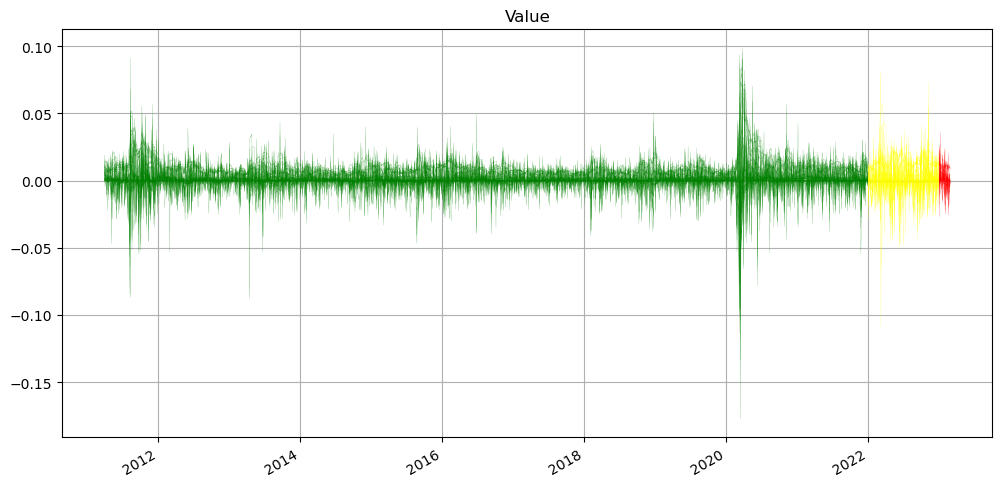

In [25]:
fig, ax = plt.subplots(1)
train_df.plot(title='Value', figsize=(12, 6), grid=True, ax=ax, color='green', lw=0.1, legend=False);
val_df.plot(title='Value', figsize=(12, 6), grid=True, ax=ax, color='yellow', lw=0.1, legend=False);
test_df.plot(title='Value', figsize=(12, 6), grid=True, ax=ax, color='red', lw=0.1, legend=False);

In [ ]:
df.to_csv('data/asset_classes_stationary_features.csv')
train_df.to_csv('data/asset_classes_stationary_features_train.csv')
val_df.to_csv('data/asset_classes_stationary_features_val.csv')
test_df.to_csv('data/asset_classes_stationary_features_test.csv')